# Cycling Data Analysis
## Workflow Example for Reproducible Analyses

Based on [Youtube Series by Jake Vanderplas](https://www.youtube.com/watch?v=_ZEWDGpM-vM&list=PLYCpMb24GpOC704uO9svUrihl-HY1tTJJ) but updated to focus on analysis of bridge use pre/post COVID-19.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

## Get data

In [2]:
# Get the data
from jupyterworkflow.data import get_fremont_data
data = get_fremont_data()

## Exploratory analysis

<Figure size 720x720 with 0 Axes>

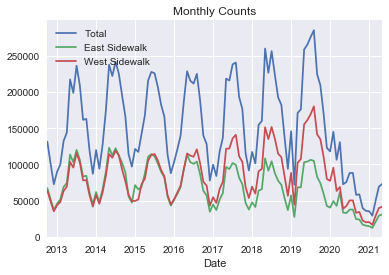

In [3]:
# Quick visualizations
plt.figure(figsize=(10,10))

# Plot monthly totals
data.resample('M').sum().plot(title='Monthly Counts')
plt.show()

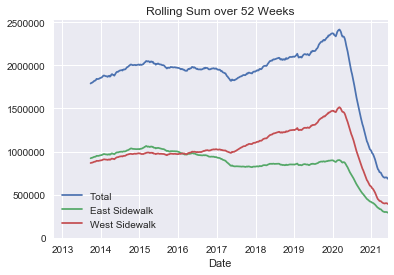

In [4]:
# Rolling sum over 52 weeks of data
# Each point on the plot is the sum of the previous 52 weeks
ax = data.resample('W').sum().rolling(52).sum().plot(title='Rolling Sum over 52 Weeks')
ax.set_ylim(0,None)
plt.show()

## Split data based on relationship with COVID-19

In [5]:
# Split data pre-covid and post-covid
# We'll say that covid started on 3/01/2020
covid_start_date = '2020-03-01'
pre_covid = data[data.index < covid_start_date]
post_covid = data[data.index > covid_start_date]

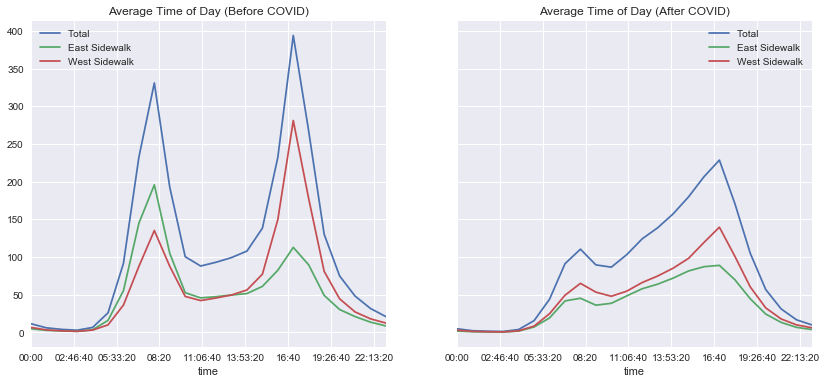

In [6]:
# Across the entire dataset, average the time that riders are using the bridge
fig,ax = plt.subplots(1,2,figsize=(14,6),sharex=True,sharey=True)
pre_covid.groupby(pre_covid.index.time).mean().plot(title='Average Time of Day (Before COVID)',ax=ax[0])
post_covid.groupby(post_covid.index.time).mean().plot(title='Average Time of Day (After COVID)',ax=ax[1])
plt.show()

In [7]:
# There is definitely a major change before and after COVID

# Let's put the Total Riders data from the post COVID dataframe in a pivot table
# This is a 2D dataframe where each column is a day and each row is an hour during that day
pivoted_post_covid = post_covid.pivot_table('Total', index=post_covid.index.time,columns = post_covid.index.date)

# Look at the first few days of data
pivoted_post_covid.iloc[0:24,0:5]

,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05
00:00:00,NaN,3.0,4.0,7.0,1.0
01:00:00,5.0,1.0,0.0,1.0,3.0
02:00:00,1.0,0.0,1.0,0.0,1.0
03:00:00,1.0,0.0,1.0,1.0,0.0
04:00:00,4.0,9.0,9.0,9.0,7.0
05:00:00,2.0,31.0,25.0,23.0,22.0
06:00:00,12.0,123.0,131.0,151.0,117.0
07:00:00,31.0,349.0,360.0,371.0,257.0
08:00:00,33.0,470.0,568.0,543.0,360.0
09:00:00,71.0,276.0,286.0,263.0,201.0


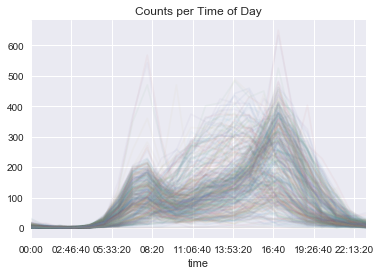

In [8]:
# Plot the pivot table data. 
# This will give us a line for each day of the year.
pivoted_post_covid.plot(legend=False,alpha=0.05,title='Counts per Time of Day')
plt.show()

## Principal component analysis

In [10]:
# It's harder to distinguish weekends from weekdays after covid
# Compare with the dataset analyzed in the YouTube series

# We can do a principal component analysis to reduce the 24 observations on each day to only 2
# let X be the number of riders per hour in pivoted_post_covid table
# Replace all na values with 0
X = pivoted_post_covid.T.fillna(0).values
X.shape

(457, 24)

In [11]:
# Principal component analysis
X2 = PCA(2,svd_solver='full').fit_transform(X)

In [12]:
X2.shape

(457, 2)

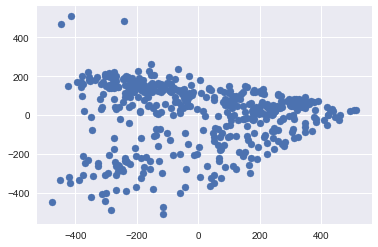

In [13]:
plt.scatter(X2[:,0],X2[:,1])

## Unsupervised clustering

In [15]:
# Let's cluster the days and see if they're distinguishable
gmm = GaussianMixture(2)
gmm.fit(X)
labels = gmm.predict(X)

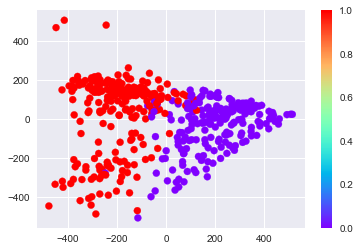

In [16]:
plt.scatter(X2[:,0],X2[:,1],c=labels,cmap='rainbow')
plt.colorbar()

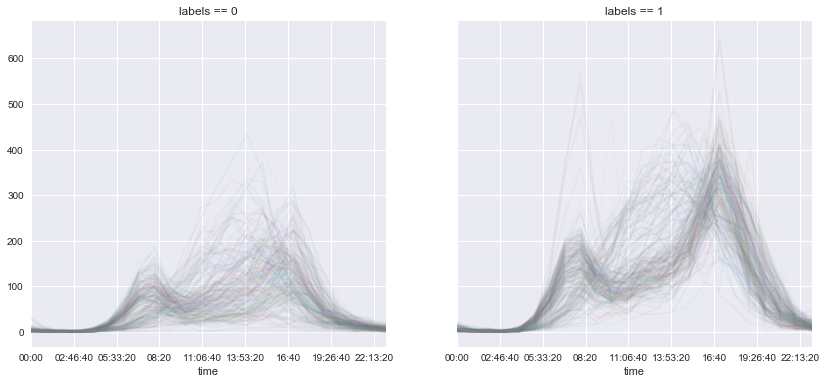

In [17]:
# for the first cluster, let's look at each day
fig,ax = plt.subplots(1,2,figsize=(14,6),sharex=True,sharey=True)
pivoted_post_covid.T[labels==0].T.plot(legend=False,alpha=0.05,ax=ax[0],title='labels == 0')
# for the second cluster, let's look at each day
pivoted_post_covid.T[labels==1].T.plot(legend=False,alpha=0.05,ax=ax[1],title='labels == 1')

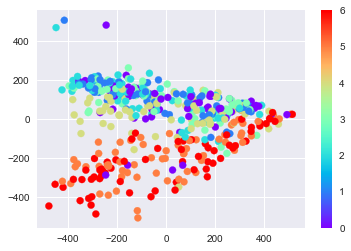

In [18]:
# These two clusters are far more similiar looking. This isn't the case with the pre-covid data.
# we'll say that labels == 0 is a weekday (regular commute peaks) and labels == 1 is a weekend
# again, see YouTube analysis for comparison
dayofweek = pd.DatetimeIndex(pivoted_post_covid.columns).dayofweek
plt.scatter(X2[:,0],X2[:,1],c=dayofweek,cmap='rainbow')
plt.colorbar()

In [19]:
# Can we pick out unexpected "weekend-looking" weekdays?
# to do this, recall that labels == 0 was a weekday and labels == 1 was a weekend
# so we want to find dates where the label is 1 (we thought it was a weekend) but day of week is 0, 1, 2, 3, or 4
dates = pd.DatetimeIndex(pivoted_post_covid.columns)
dates[(labels == 1) & (dayofweek < 5)]

DatetimeIndex(['2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05',
               '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-16', '2020-03-17',
               ...
               '2021-05-13', '2021-05-14', '2021-05-18', '2021-05-19',
               '2021-05-20', '2021-05-21', '2021-05-25', '2021-05-26',
               '2021-05-28', '2021-05-31'],
              dtype='datetime64[ns]', length=176, freq=None)

## Conclusions
* It seems harder to distinguish weekends from weekdays after COVID, at least insofar as bicycle commutes in one city are concerned.
    * The "weekend-looking" weekdays (i.e. holidays) aren't recognizable dates.